# K Nearest Neighbors Model with Bayes

Refined kNN classification model with Bayesian input from the very-accurate breed classification

# Imports

In [1]:
## Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style
import csv
set_style("whitegrid")

## More specific imports for this notebook
import joblib ## For saving trained models
from sklearn.neighbors import KNeighborsClassifier ## Import the model here
from sklearn.model_selection import train_test_split ## Import train_test_split
from sklearn.metrics import confusion_matrix ## Import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score

# Initial Settings and Load Data

In [2]:
X_orig = np.load('../../data/processed_data/specgram_db_pad_trunc.npy')

X_specaug1 = np.load('../../data/processed_data/augment_data/spec_pt_ftmask1.npy')
X_tsh1 = np.load('../../data/processed_data/augment_data/spec_pt_timeshift1.npy')
X_randn1 = np.load('../../data/processed_data/augment_data/spec_pt_randnoise1.npy')
X_tstr1 = np.load('../../data/processed_data/augment_data/spec_pt_timestretch1.npy')

X_specaug2 = np.load('../../data/processed_data/augment_data/spec_pt_ftmask2.npy')
X_tsh2 = np.load('../../data/processed_data/augment_data/spec_pt_timeshift2.npy')
X_randn2 = np.load('../../data/processed_data/augment_data/spec_pt_randnoise2.npy')
X_tstr2 = np.load('../../data/processed_data/augment_data/spec_pt_timestretch2.npy')

X_specaug3 = np.load('../../data/processed_data/augment_data/spec_pt_ftmask3.npy')
X_tsh3 = np.load('../../data/processed_data/augment_data/spec_pt_timeshift3.npy')
X_randn3 = np.load('../../data/processed_data/augment_data/spec_pt_randnoise3.npy')
X_tstr3 = np.load('../../data/processed_data/augment_data/spec_pt_timestretch3.npy')

In [3]:
## Choose what to add to the orignal data
x_data = np.concatenate((X_orig,X_specaug1), axis=0)
X = []
for x in x_data:
    X.append(x.flatten())
aug_file = 'specaug1' #Update when we want to save a file!!!

df = pd.read_csv("../../data/processed_data/metadata.csv")

## Choose which category we are dealing with
situation_to_number = {'brushing': 0, 'food': 1, 'isolation': 2}
sex_to_number = {0:0, 1:1} ## Sex already transfered to number; this is for uniformity of the code
breed_to_number = {'european_shorthair': 0, 'maine_coon': 1}

## Create a new column with numerical values based on the situation mapping
model_types = ['situation', 'sex', 'breed'] 
model_type = model_types[0] + '_' + model_types[1] + '_' + model_types[2]
situation_sex_type = model_types[0] + '_given_' + model_types[1]
situation_breed_type = model_types[0] + '_given_' + model_types[2]

df['numerical_'+model_types[0]] = df[model_types[0]].map(situation_to_number)
df['numerical_'+model_types[1]] = df[model_types[1]].map(sex_to_number)
df['numerical_'+model_types[2]] = df[model_types[2]].map(breed_to_number)
df['numerical_'+situation_sex_type] = 2*df['numerical_'+model_types[0]] + df['numerical_'+model_types[1]]
df['numerical_'+situation_breed_type] = 2*df['numerical_'+model_types[0]] + df['numerical_'+model_types[2]]
df['numerical_'+model_type] = 4*df['numerical_'+model_types[0]] + 2*df['numerical_'+model_types[1]] + df['numerical_'+model_types[2]]

y_situation = np.concatenate((df['numerical_'+model_types[0]].values, df['numerical_'+model_types[0]].values), axis=0)
y_sex = np.concatenate((df['numerical_'+model_types[1]].values, df['numerical_'+model_types[1]].values), axis=0)
y_breed = np.concatenate((df['numerical_'+model_types[2]].values, df['numerical_'+model_types[2]].values), axis=0)
y_situation_sex = np.concatenate((df['numerical_'+situation_sex_type].values, df['numerical_'+situation_sex_type].values), axis=0)
y_situation_breed = np.concatenate((df['numerical_'+situation_breed_type].values, df['numerical_'+situation_breed_type].values), axis=0)

y_orig = df['numerical_'+model_type].values
y = np.concatenate((y_orig, y_orig), axis=0)

X_sit_sex_split = [[],[]]
y_sit_sex_split = [[],[]]
X_sit_breed_split = [[],[]]
y_sit_breed_split = [[],[]]
for a in range(0,len(X)):
    X_sit_sex_split[ y_situation_sex[a]%2 ].append(X[a])
    y_sit_sex_split[ y_situation_sex[a]%2 ].append(y[a])
    X_sit_breed_split[ y_situation_breed[a]%2 ].append(X[a])
    y_sit_breed_split[ y_situation_breed[a]%2 ].append(y[a])
    


print(x_data.shape)
print(y_orig.shape)
print(y_situation.shape)
print(y_sex.shape)
print(y_breed.shape)
print(y_situation_sex.shape)
print(y_situation_breed.shape)
print(len(y_sit_sex_split[0]), len(y_sit_sex_split[1]))
print(len(y_sit_breed_split[0]), len(y_sit_breed_split[1]))
print(y.shape)

(880, 128, 67)
(440,)
(880,)
(880,)
(880,)
(880,)
(880,)
690 190
504 376
(880,)


# Train Test Splits

In [4]:
## Set up the train test splits we need

#Use these variables to automate saving runs with different filesnames
test_size = 1/5
random_state = 440

## Train test split for all three simultaneously
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(X.copy(), y,
                                        shuffle = True,
                                        random_state = random_state,
                                        test_size = test_size)

## Train test split for modelinlg the situation 
x_train_sit, x_test_sit, y_train_sit, y_test_sit = train_test_split(X.copy(), y_situation,
                                        shuffle = True,
                                        random_state = random_state,
                                        test_size = test_size)

## Train test split for modelinlg the sex
x_train_sex, x_test_sex, y_train_sex, y_test_sex = train_test_split(X.copy(), y_sex,
                                        shuffle = True,
                                        random_state = random_state,
                                        test_size = test_size)

## Train test split for modelinlg the breed
x_train_breed, x_test_breed, y_train_breed, y_test_breed = train_test_split(X.copy(), y_breed,
                                        shuffle = True,
                                        random_state = random_state,
                                        test_size = test_size)

## Train test split for modelinlg the combined situation-sex combination
x_train_sit_sex, x_test_sit_sex, y_train_sit_sex, y_test_sit_sex = train_test_split(X.copy(), y_situation_sex,
                                        shuffle = True,
                                        random_state = random_state,
                                        test_size = test_size)

## Train test split for modelinlg the combined situation-breed combination
x_train_sit_breed, x_test_sit_breed, y_train_sit_breed, y_test_sit_breed = train_test_split(X.copy(), y_situation_breed,
                                        shuffle = True,
                                        random_state = random_state,
                                        test_size = test_size)

## Train test split to modeling the situation for males
x_train_males, x_test_males, y_train_males, y_test_males = train_test_split(X_sit_sex_split[0].copy(), y_sit_sex_split[0],
                                        shuffle = True,
                                        random_state = random_state,
                                        test_size = test_size)

## Train test split for modeling the situation for females
x_train_females, x_test_females, y_train_females, y_test_females = train_test_split(X_sit_sex_split[1].copy(), y_sit_sex_split[1],
                                        shuffle = True,
                                        random_state = random_state,
                                        test_size = test_size)

## Train test split to modeling the situation for shorthairs
x_train_sh, x_test_sh, y_train_sh, y_test_sh = train_test_split(X_sit_breed_split[0].copy(), y_sit_breed_split[0],
                                        shuffle = True,
                                        random_state = random_state,
                                        test_size = test_size)

## Train test split for modeling the situation for maine coons
x_train_mc, x_test_mc, y_train_mc, y_test_mc = train_test_split(X_sit_breed_split[1].copy(), y_sit_breed_split[1],
                                        shuffle = True,
                                        random_state = random_state,
                                        test_size = test_size)

# Fit Models

In [11]:
## Use these variables later to automate saving runs with different filesnames

k_list = np.arange(1,16)

## Make lists of model objects
knn_all_list = [KNeighborsClassifier(k) for k in k_list]
knn_situation_list = [KNeighborsClassifier(k) for k in k_list]
knn_sex_list = [KNeighborsClassifier(k) for k in k_list]
knn_breed_list = [KNeighborsClassifier(k) for k in k_list]
knn_sit_sex_list = [KNeighborsClassifier(k) for k in k_list]
knn_sit_breed_list = [KNeighborsClassifier(k) for k in k_list]
knn_males_list = [KNeighborsClassifier(k) for k in k_list]
knn_females_list = [KNeighborsClassifier(k) for k in k_list]
knn_shorthair_list = [KNeighborsClassifier(k) for k in k_list]
knn_mainecoon_list = [KNeighborsClassifier(k) for k in k_list]

## Fit the model object
for k in k_list:
    knn_all_list[k-1].fit(x_train_all, y_train_all)
    knn_situation_list[k-1].fit(x_train_sit, y_train_sit)
    knn_sex_list[k-1].fit(x_train_sex, y_train_sex)
    knn_breed_list[k-1].fit(x_train_breed, y_train_breed)
    knn_sit_sex_list[k-1].fit(x_train_sit_sex, y_train_sit_sex)
    knn_sit_breed_list[k-1].fit(x_train_sit_breed, y_train_sit_breed)
    knn_males_list[k-1].fit(x_train_males, y_train_males)
    knn_females_list[k-1].fit(x_train_females, y_train_females)
    knn_shorthair_list[k-1].fit(x_train_sh, y_train_sh)
    knn_mainecoon_list[k-1].fit(x_train_mc, y_train_mc)

[KNeighborsClassifier(n_neighbors=1), KNeighborsClassifier(n_neighbors=2), KNeighborsClassifier(n_neighbors=3), KNeighborsClassifier(n_neighbors=4), KNeighborsClassifier(), KNeighborsClassifier(n_neighbors=6), KNeighborsClassifier(n_neighbors=7), KNeighborsClassifier(n_neighbors=8), KNeighborsClassifier(n_neighbors=9), KNeighborsClassifier(n_neighbors=10), KNeighborsClassifier(n_neighbors=11), KNeighborsClassifier(n_neighbors=12), KNeighborsClassifier(n_neighbors=13), KNeighborsClassifier(n_neighbors=14), KNeighborsClassifier(n_neighbors=15)]


# Assess Model Performances

In [12]:
## Predict on the training sets
y_test_pred_all = [model.predict(x_test_all) for model in knn_all_list]
y_test_pred_sit = [model.predict(x_test_sit) for model in knn_situation_list]
y_test_pred_sex = [model.predict(x_test_sex) for model in knn_sex_list]
y_test_pred_breed = [model.predict(x_test_breed) for model in knn_breed_list]
y_test_pred_sit_sex = [model.predict(x_test_sit_sex) for model in knn_sit_sex_list]
y_test_pred_sit_breed = [model.predict(x_test_sit_breed) for model in knn_breed_list]
y_test_pred_males = [model.predict(x_test_males) for model in knn_males_list]
y_test_pred_females = [model.predict(x_test_females) for model in knn_females_list]
y_test_pred_sh = [model.predict(x_test_sh) for model in knn_shorthair_list]
y_test_pred_mc = [model.predict(x_test_mc) for model in knn_mainecoon_list]

## Compute confusion matrix for each model
conf_mat_all = [confusion_matrix(y_test_all, y_test_pred_all[i]) for i in range(0,len(k_list))]
conf_mat_situation = [confusion_matrix(y_test_sit, y_test_pred_sit[i]) for i in range(0,len(k_list))]
conf_mat_sex = [confusion_matrix(y_test_sex, y_test_pred_sex[i]) for i in range(0,len(k_list))]
conf_mat_breed = [confusion_matrix(y_test_breed, y_test_pred_breed[i]) for i in range(0,len(k_list))]
conf_mat_sit_sex = [confusion_matrix(y_test_sit_sex, y_test_pred_sit_sex[i]) for i in range(0,len(k_list))]
conf_mat_sit_breed = [confusion_matrix(y_test_sit_breed, y_test_pred_sit_breed[i]) for i in range(0,len(k_list))]
conf_mat_males = [confusion_matrix(y_test_males, y_test_pred_males[i]) for i in range(0,len(k_list))]
conf_mat_females = [confusion_matrix(y_test_females, y_test_pred_females[i]) for i in range(0,len(k_list))]
conf_mat_shorthair = [confusion_matrix(y_test_sh, y_test_pred_sh[i]) for i in range(0,len(k_list))]
conf_mat_mainecoon = [confusion_matrix(y_test_mc, y_test_pred_mc[i]) for i in range(0,len(k_list))]

## Compute accuracy for the model
acc_all = [accuracy_score(y_test_all, y_test_pred_all[i]) for i in range(0,len(k_list))]
acc_situation = [accuracy_score(y_test_sit, y_test_pred_sit[i]) for i in range(0,len(k_list))]
acc_sex = [accuracy_score(y_test_sex, y_test_pred_sex[i]) for i in range(0,len(k_list))]
acc_breed = [accuracy_score(y_test_breed, y_test_pred_breed[i]) for i in range(0,len(k_list))]
acc_sit_sex = [accuracy_score(y_test_sit_sex, y_test_pred_sit_sex[i]) for i in range(0,len(k_list))]
acc_sit_breed = [accuracy_score(y_test_sit_breed, y_test_pred_sit_breed[i]) for i in range(0,len(k_list))]
acc_males = [accuracy_score(y_test_males, y_test_pred_males[i]) for i in range(0,len(k_list))]
acc_females = [accuracy_score(y_test_females, y_test_pred_females[i]) for i in range(0,len(k_list))]
acc_shorthair = [accuracy_score(y_test_sh, y_test_pred_sh[i]) for i in range(0,len(k_list))]
acc_mainecoon = [accuracy_score(y_test_mc, y_test_pred_mc[i]) for i in range(0,len(k_list))]

## Compute precicions for each model
print(y_test_pred_all[0])
prec_all = [precision_score(y_test_all, y_test_pred_all[i], average='macro') for i in range(0,len(k_list))]
prec_situation = [precision_score(y_test_sit, y_test_pred_sit[i], average='macro') for i in range(0,len(k_list))]
prec_sex = [precision_score(y_test_sex, y_test_pred_sex[i], average='macro') for i in range(0,len(k_list))]
prec_breed = [precision_score(y_test_breed, y_test_pred_breed[i], average='macro') for i in range(0,len(k_list))]
prec_sit_sex = [precision_score(y_test_sit_sex, y_test_pred_sit_sex[i], average='macro') for i in range(0,len(k_list))]
prec_sit_breed = [precision_score(y_test_sit_breed, y_test_pred_sit_breed[i], average='macro') for i in range(0,len(k_list))]
prec_males = [precision_score(y_test_males, y_test_pred_males[i], average='macro') for i in range(0,len(k_list))]
prec_females = [precision_score(y_test_females, y_test_pred_females[i], average='macro') for i in range(0,len(k_list))]
prec_shorthair = [precision_score(y_test_sh, y_test_pred_sh[i], average='macro') for i in range(0,len(k_list))]
prec_mainecoon = [precision_score(y_test_mc, y_test_pred_mc[i], average='macro') for i in range(0,len(k_list))]

## Compute recalls for each model
recall_all = [recall_score(y_test_all, y_test_pred_all[i], average='macro') for i in range(0,len(k_list))]
recall_situation = [recall_score(y_test_sit, y_test_pred_sit[i], average='macro') for i in range(0,len(k_list))]
recall_sex = [recall_score(y_test_sex, y_test_pred_sex[i], average='macro') for i in range(0,len(k_list))]
recall_breed = [recall_score(y_test_breed, y_test_pred_breed[i], average='macro') for i in range(0,len(k_list))]
recall_sit_sex = [recall_score(y_test_sit_sex, y_test_pred_sit_sex[i], average='macro') for i in range(0,len(k_list))]
recall_sit_breed = [recall_score(y_test_sit_breed, y_test_pred_sit_breed[i], average='macro') for i in range(0,len(k_list))]
recall_males = [recall_score(y_test_males, y_test_pred_males[i], average='macro') for i in range(0,len(k_list))]
recall_females = [recall_score(y_test_females, y_test_pred_females[i], average='macro') for i in range(0,len(k_list))]
recall_shorthair = [recall_score(y_test_sh, y_test_pred_sh[i], average='macro') for i in range(0,len(k_list))]
recall_mainecoon = [recall_score(y_test_mc, y_test_pred_mc[i], average='macro') for i in range(0,len(k_list))]


## Print out collective data
print('All three category accuracy:', acc_all)
print()
print('Situation accuracy:', acc_situation)
print()
print('Sex accuracy:', acc_sex)
print()
print('Breed accuracy:', acc_breed)
print()
print('(Situation | Male) accuracy:', acc_males)
print()
print('(Situation | Female) accuracy:', acc_females)
print()
print('(Situation | Sex) accuracy:', acc_sit_sex)
print()
print('(Situation | European Shorthair) accuracy:', acc_shorthair)
print()
print('(Situation | Maine Coon) accuracy:', acc_mainecoon)
print()
print('(Situation | Breed) accuracy:', acc_sit_breed)
print()
print()
print('----- Confusion matrices -----')
print()
print()
print('All three categories confusion matrix:')
print()
print(conf_mat_all)
print()
print()
print('Situation confusion matrix:')
print()
print(conf_mat_situation)
print()
print()
print('Sex confusion matrix:')
print()
print(conf_mat_sex)
print()
print()
print('Breed confusion matrix:')
print()
print(conf_mat_breed)
print()
print()
print('(Situation | Male) confusion matrix:')
print()
print(conf_mat_males)
print()
print()
print('(Situation | Female) confusion matrix:')
print()
print(conf_mat_females)
print()
print()
print('(Situation | Sex) confusion matrix:')
print()
print(conf_mat_sit_sex)
print()
print()
print('(Situation | European Shorthair) confusion matrix:')
print()
print(conf_mat_shorthair)
print()
print()
print('(Situation | Maine Coon) confusion matrix:')
print()
print(conf_mat_mainecoon)
print()
print()
print('(Situation | Breed) confusion matrix:')
print()
print(conf_mat_sit_breed)
print()
print('----------------------------------------------------------------------------------------------------')

[ 9  3  8  9  9  0 11  8  9  4  8  9  4  0  2  1  8  8  6  8  9  8  8  8
 10 10  9  8 10  2  4  0 11  0  8  9  0  4  5  7  6  8  3  9  3  8  1  8
  6  2  1  0  8  9 11  7  4  8  8 11  9  8  5  9  5  5  0  8  8  8  0  4
  1  1  6  9  8  8  0  0  8 11  8  3  9  0  4  8  0 11  4  0  3  4  1  0
  4  8  9 10  4  8  9  7  9  9  5  9  9  0  9  8  3  0  7  4  4  8  1  8
  5  0  7  8  2  5  0  9  3  0  1  8  6  9  9  4  8  9  0  9  8  9  7  0
  8 11  9  8  1  8  0  9  1  9  6  5  1  8  1  9  8  8  4  1  9  3  0  8
  6 11  4  1  1  0  0  8]


C:\Users\willc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\willc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\willc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\willc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedM

All three category accuracy: [0.9204545454545454, 0.7840909090909091, 0.7556818181818182, 0.6761363636363636, 0.7159090909090909, 0.6590909090909091, 0.6420454545454546, 0.6647727272727273, 0.6079545454545454, 0.6079545454545454, 0.6193181818181818, 0.5909090909090909, 0.5795454545454546, 0.5909090909090909, 0.5909090909090909]

Situation accuracy: [0.9375, 0.8125, 0.8011363636363636, 0.7215909090909091, 0.7443181818181818, 0.7215909090909091, 0.6988636363636364, 0.7045454545454546, 0.6818181818181818, 0.6704545454545454, 0.6704545454545454, 0.6534090909090909, 0.6534090909090909, 0.6534090909090909, 0.6420454545454546]

Sex accuracy: [0.9488636363636364, 0.9204545454545454, 0.9034090909090909, 0.9034090909090909, 0.8863636363636364, 0.875, 0.8522727272727273, 0.8693181818181818, 0.8636363636363636, 0.875, 0.875, 0.8920454545454546, 0.8806818181818182, 0.875, 0.8806818181818182]

Breed accuracy: [1.0, 0.9829545454545454, 0.9772727272727273, 0.9829545454545454, 0.9886363636363636, 0.982

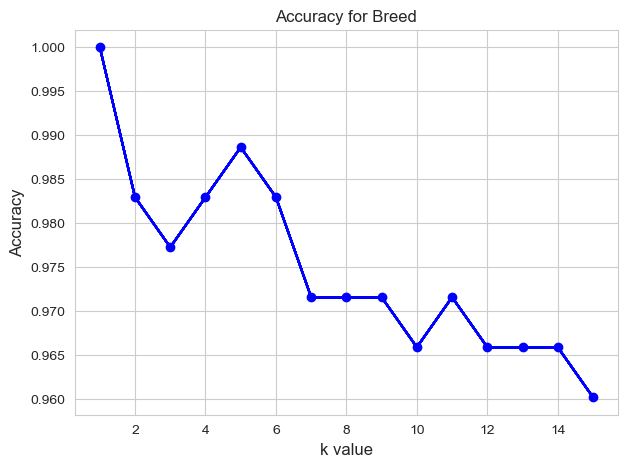

In [13]:
## Plotting precision-recall graphs

#all = [confusion_matrix(y_test_all, y_test_pred_all[i]) for i in range(0,len(k_list))]
#situation = [confusion_matrix(y_test_sit, y_test_pred_sit[i]) for i in range(0,len(k_list))]
#sex = [confusion_matrix(y_test_sex, y_test_pred_sex[i]) for i in range(0,len(k_list))]
#breed = [confusion_matrix(y_test_breed, y_test_pred_breed[i]) for i in range(0,len(k_list))]
#sit_sex = [confusion_matrix(y_test_sit_sex, y_test_pred_sit_sex[i]) for i in range(0,len(k_list))]
#sit_breed = [confusion_matrix(y_test_sit_breed, y_test_pred_sit_breed[i]) for i in range(0,len(k_list))]
#males = [confusion_matrix(y_test_males, y_test_pred_males[i]) for i in range(0,len(k_list))]
#females = [confusion_matrix(y_test_females, y_test_pred_females[i]) for i in range(0,len(k_list))]
#shorthair = [confusion_matrix(y_test_sh, y_test_pred_sh[i]) for i in range(0,len(k_list))]
#mainecoon = [confusion_matrix(y_test_mc, y_test_pred_mc[i]) for i in range(0,len(k_list))]

## Customize these for each case above
acc_scores = acc_breed
String = "Breed"

plt.figure(figsize=(7,5))

#plt.plot(rec_scores, prec_scores)

plt.title("Accuracy for "+String)
plt.xlabel("k value", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

for k in k_list:
    plt.plot(k_list, acc_scores,'b')
    plt.plot(k_list[k-1], acc_scores[k-1], 'bo')

#horizontalalignment='center',verticalalignment='bottom'

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

# A couple data points for X_specaug1

----------------------------------------------------------------------------------------------------

k = 1 used for these kNN models


All three category accuracy: 0.9204545454545454

Situation accuracy: 0.9375

Sex accuracy: 0.9488636363636364

Breed accuracy: 1.0

Independence product: 0.8895596590909091


(Situation | Male) accuracy: 0.8768115942028986

(Situation | Female) accuracy: 0.8947368421052632

(Situation | Sex) accuracy: 0.9204545454545454

(Situation | European Shorthair) accuracy: 0.9405940594059405

(Situation | Maine Coon) accuracy: 0.9210526315789473

(Situation | Breed) accuracy: 0.9375


----- Confusion matrices -----


All three categories confusion matrix:

[[25  0  1  0  0  0  0  0  1  0  0  0]
 [ 0 15  0  0  0  1  0  0  0  0  0  2]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  1  0  0]
 [ 0  0  0  0  1  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  2  0  0  0  0  0 42  0  0  0]
 [ 0  0  0  0  0  2  0  2  0 30  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  6]]


Situation confusion matrix:

[[50  1  3]
 [ 0 32  1]
 [ 2  4 83]]


Sex confusion matrix:

[[137   7]
 [  2  30]]


Breed confusion matrix:

[[99  0]
 [ 0 77]]


(Situation | Male) confusion matrix:

[[24  0  2  0  2  3]
 [ 0 16  0  0  0  2]
 [ 0  0  9  0  1  0]
 [ 0  3  0  3  0  4]
 [ 0  0  0  0 50  0]
 [ 0  0  0  0  0 19]]


(Situation | Female) confusion matrix:

[[1 0 0 0 0 0]
 [0 8 0 2 0 1]
 [0 0 6 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 6 0]
 [0 0 0 1 0 8]]


(Situation | Sex) confusion matrix:

[[40  1  1  0  1  2]
 [ 0  9  0  0  0  0]
 [ 0  0 20  0  1  0]
 [ 0  0  1 11  0  0]
 [ 0  2  2  2 72  0]
 [ 0  0  0  0  1 10]]


(Situation | European Shorthair) confusion matrix:

[[28  0  2  0  1  1]
 [ 0  1  0  0  0  0]
 [ 1  0 12  0  0  0]
 [ 0  0  0  2  0  0]
 [ 0  0  1  0 45  0]
 [ 0  0  0  0  0  7]]


(Situation | Maine Coon) confusion matrix:

[[11  3  1  0  2  0]
 [ 0  3  0  0  0  0]
 [ 0  0 13  0  0  0]
 [ 0  0  0  5  0  0]
 [ 0  0  0  0 25  0]
 [ 0  0  0  0  0 13]]


(Situation | Breed) confusion matrix:

[[27  0  0  0  1  0]
 [ 0 23  0  1  0  2]
 [ 0  0 23  0  0  0]
 [ 0  0  0  9  0  1]
 [ 2  0  0  0 46  0]
 [ 0  0  0  4  0 37]]
 
----------------------------------------------------------------------------------------------------

k = 2 used for these kNN models


All three category accuracy: 0.7840909090909091

Situation accuracy: 0.8125

Sex accuracy: 0.9204545454545454

Breed accuracy: 0.9829545454545454

Independence product: 0.7351215457128099


(Situation | Male) accuracy: 0.8768115942028986

(Situation | Female) accuracy: 0.8421052631578947

(Situation | Sex) accuracy: 0.7840909090909091

(Situation | European Shorthair) accuracy: 0.8217821782178217

(Situation | Maine Coon) accuracy: 0.7763157894736842

(Situation | Breed) accuracy: 0.8068181818181818


----- Confusion matrices -----


All three categories confusion matrix:

[[25  0  2  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  7  0  0  0  0  0  0  0  0]
 [ 7  0  0  1  7  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0  0  0]
 [ 1  0  1  0  1  0  5  0  0  0  0  0]
 [ 1  0  0  0  1  0  0  2  0  0  0  0]
 [ 5  0  3  0  2  0  0  0 34  0  0  0]
 [ 0  1  0  1  0  2  0  2  0 28  0  0]
 [ 0  0  1  0  0  0  1  0  0  0  2  0]
 [ 0  0  0  0  1  1  0  0  0  0  0  5]]


Situation confusion matrix:

[[52  0  2]
 [11 22  0]
 [11  9 69]]


Sex confusion matrix:

[[141   3]
 [ 11  21]]


Breed confusion matrix:

[[99  0]
 [ 3 74]]


(Situation | Male) confusion matrix:

[[29  1  0  0  1  0]
 [ 0 16  0  1  0  1]
 [ 1  0  9  0  0  0]
 [ 0  6  0  3  0  1]
 [ 1  1  3  0 45  0]
 [ 0  0  0  0  0 19]]


(Situation | Female) confusion matrix:

[[1 0 0 0 0 0]
 [0 9 0 2 0 0]
 [0 0 6 0 0 0]
 [0 0 1 4 0 0]
 [0 0 1 0 5 0]
 [0 1 0 1 0 7]]


(Situation | Sex) confusion matrix:

[[41  2  0  0  0  2]
 [ 1  8  0  0  0  0]
 [ 7  1 13  0  0  0]
 [ 2  1  2  7  0  0]
 [ 6  4  4  2 62  0]
 [ 0  1  2  1  0  7]]


(Situation | European Shorthair) confusion matrix:

[[29  0  2  0  0  1]
 [ 0  1  0  0  0  0]
 [ 6  0  7  0  0  0]
 [ 0  0  0  2  0  0]
 [ 4  0  1  1 40  0]
 [ 0  0  0  2  1  4]]


(Situation | Maine Coon) confusion matrix:

[[11  4  0  0  2  0]
 [ 2  1  0  0  0  0]
 [ 2  0 11  0  0  0]
 [ 1  0  0  4  0  0]
 [ 0  0  2  0 23  0]
 [ 0  0  1  1  2  9]]


(Situation | Breed) confusion matrix:

[[28  0  0  0  0  0]
 [ 0 24  0  0  0  2]
 [ 9  1 13  0  0  0]
 [ 1  0  1  8  0  0]
 [ 9  0  3  0 36  0]
 [ 0  2  1  5  0 33]]
 
----------------------------------------------------------------------------------------------------

k = 3 used for these kNN models


All three category accuracy: 0.7556818181818182

Situation accuracy: 0.8011363636363636

Sex accuracy: 0.9034090909090909

Breed accuracy: 0.9772727272727273

Independence product: 0.7073049222858753


(Situation | Male) accuracy: 0.782608695652174

(Situation | Female) accuracy: 0.7368421052631579

(Situation | Sex) accuracy: 0.7556818181818182

(Situation | European Shorthair) accuracy: 0.7821782178217822

(Situation | Maine Coon) accuracy: 0.7105263157894737

(Situation | Breed) accuracy: 0.7897727272727273


----- Confusion matrices -----


All three categories confusion matrix:

[[22  0  0  0  2  1  0  0  2  0  0  0]
 [ 0 10  0  0  0  3  0  1  0  2  0  2]
 [ 0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  1  0  7  0  0  0  0  0  0  0  0]
 [ 3  0  0  0 10  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  5  0  1  0  0  0  0]
 [ 1  0  0  0  1  1  5  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  2  0  0  0  0]
 [ 4  0  2  0  1  0  0  0 37  0  0  0]
 [ 0  0  0  1  0  3  0  2  0 28  0  0]
 [ 0  0  1  0  0  0  1  0  0  0  2  0]
 [ 0  0  0  0  1  1  0  0  0  0  0  5]]


Situation confusion matrix:

[[38  8  8]
 [ 5 24  4]
 [ 5  5 79]]


Sex confusion matrix:

[[135   9]
 [  8  24]]


Breed confusion matrix:

[[98  1]
 [ 3 74]]


(Situation | Male) confusion matrix:

[[20  1  6  1  3  0]
 [ 0 13  0  1  0  4]
 [ 1  0  7  1  1  0]
 [ 1  4  0  2  0  3]
 [ 0  1  2  0 47  0]
 [ 0  0  0  0  0 19]]


(Situation | Female) confusion matrix:

[[1 0 0 0 0 0]
 [0 7 0 2 1 1]
 [0 0 4 0 2 0]
 [0 0 0 4 0 1]
 [0 0 1 0 5 0]
 [0 1 0 1 0 7]]


(Situation | Sex) confusion matrix:

[[30  0  7  1  5  2]
 [ 1  7  0  0  1  0]
 [ 3  0 15  1  2  0]
 [ 3  0  2  7  0  0]
 [ 4  2  4  2 66  0]
 [ 0  0  2  1  0  8]]


(Situation | European Shorthair) confusion matrix:

[[23  0  3  0  4  2]
 [ 0  0  0  0  1  0]
 [ 3  0  7  1  2  0]
 [ 0  0  0  2  0  0]
 [ 3  0  1  1 41  0]
 [ 0  0  0  0  1  6]]


(Situation | Maine Coon) confusion matrix:

[[10  4  0  1  2  0]
 [ 2  1  0  0  0  0]
 [ 3  0  6  0  4  0]
 [ 1  0  1  3  0  0]
 [ 0  1  1  0 23  0]
 [ 0  1  1  0  0 11]]


(Situation | Breed) confusion matrix:

[[22  0  2  1  3  0]
 [ 0 18  0  4  0  4]
 [ 4  0 17  0  2  0]
 [ 2  0  0  6  0  2]
 [ 7  0  1  0 40  0]
 [ 0  0  1  4  0 36]]
 
 ----------------------------------------------------------------------------------------------------

k = 4 used for these kNN models


All three category accuracy: 0.6761363636363636

Situation accuracy: 0.7215909090909091

Sex accuracy: 0.9034090909090909

Breed accuracy: 0.9829545454545454

Independence product: 0.6407799953629789


(Situation | Male) accuracy: 0.717391304347826

(Situation | Female) accuracy: 0.7894736842105263

(Situation | Sex) accuracy: 0.6761363636363636

(Situation | European Shorthair) accuracy: 0.7326732673267327

(Situation | Maine Coon) accuracy: 0.6710526315789473

(Situation | Breed) accuracy: 0.7329545454545454


----- Confusion matrices -----


All three categories confusion matrix:

[[18  0  1  0  5  0  0  0  3  0  0  0]
 [ 0  9  0  0  0  3  0  2  0  2  0  2]
 [ 0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  2  0  5  0  0  0  1  0  0  0  0]
 [ 2  0  0  1  9  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  4  0  1  0  0  0  1]
 [ 2  0  0  0  0  1  5  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  2  0  0  0  0]
 [ 3  0  3  0  2  0  0  0 35  0  1  0]
 [ 0  3  0  0  0  3  0  2  0 25  0  1]
 [ 0  0  1  0  0  1  0  0  0  0  2  0]
 [ 0  0  0  0  1  1  0  0  0  0  0  5]]


Situation confusion matrix:

[[35 10  9]
 [ 6 23  4]
 [10 10 69]]


Sex confusion matrix:

[[139   5]
 [ 12  20]]


Breed confusion matrix:

[[99  0]
 [ 3 74]]


(Situation | Male) confusion matrix:

[[15  1  9  0  6  0]
 [ 0 13  0  0  1  4]
 [ 1  0  7  1  1  0]
 [ 1  3  0  3  0  3]
 [ 1  1  5  0 43  0]
 [ 0  0  0  1  0 18]]


(Situation | Female) confusion matrix:

[[1 0 0 0 0 0]
 [0 6 0 2 1 2]
 [0 0 6 0 0 0]
 [0 0 0 4 0 1]
 [0 0 1 0 5 0]
 [0 0 0 1 0 8]]


(Situation | Sex) confusion matrix:

[[25  1  9  2  6  2]
 [ 2  5  0  1  1  0]
 [ 2  1 13  1  3  1]
 [ 4  0  1  7  0  0]
 [ 6  3  5  2 61  1]
 [ 0  0  3  0  0  8]]


(Situation | European Shorthair) confusion matrix:

[[19  0  4  0  6  3]
 [ 0  0  0  0  1  0]
 [ 3  0  8  0  2  0]
 [ 0  0  0  2  0  0]
 [ 3  0  1  1 41  0]
 [ 0  0  0  2  1  4]]


(Situation | Maine Coon) confusion matrix:

[[ 9  2  1  1  4  0]
 [ 1  1  1  0  0  0]
 [ 2  0  6  0  4  1]
 [ 1  1  1  2  0  0]
 [ 1  0  0  0 24  0]
 [ 0  3  0  0  1  9]]


(Situation | Breed) confusion matrix:

[[19  0  5  0  4  0]
 [ 0 18  0  4  0  4]
 [ 3  1 15  1  3  0]
 [ 2  0  0  7  0  1]
 [ 7  0  2  0 39  0]
 [ 0  3  1  6  0 31]]
 
 ----------------------------------------------------------------------------------------------------

k = 5 used for these kNN models


All three category accuracy: 0.7159090909090909

Situation accuracy: 0.7443181818181818

Sex accuracy: 0.8863636363636364

Breed accuracy: 0.9886363636363636

Independence product: 0.6522395637678438


(Situation | Male) accuracy: 0.7246376811594203

(Situation | Female) accuracy: 0.7368421052631579

(Situation | Sex) accuracy: 0.7102272727272727

(Situation | European Shorthair) accuracy: 0.7029702970297029

(Situation | Maine Coon) accuracy: 0.6578947368421053

(Situation | Breed) accuracy: 0.75


----- Confusion matrices -----


All three categories confusion matrix:

[[18  0  1  0  2  1  0  0  5  0  0  0]
 [ 0 10  0  0  0  1  0  2  0  3  0  2]
 [ 0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  1  0  6  0  0  0  1  0  0  0  0]
 [ 1  0  0  1 11  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  4  0  1  0  1  0  0]
 [ 0  0  1  0  0  1  6  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  2  0  0  0  0]
 [ 4  0  2  0  1  0  0  0 35  0  1  1]
 [ 0  1  0  0  0  3  0  2  0 27  0  1]
 [ 0  0  1  0  0  1  0  0  0  0  2  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  5]]


Situation confusion matrix:

[[31  9 14]
 [ 5 24  4]
 [ 6  7 76]]


Sex confusion matrix:

[[133  11]
 [  9  23]]


Breed confusion matrix:

[[99  0]
 [ 2 75]]


(Situation | Male) confusion matrix:

[[15  1  9  0  6  0]
 [ 0 10  0  2  1  5]
 [ 1  0  8  1  0  0]
 [ 1  2  0  3  0  4]
 [ 0  0  4  0 46  0]
 [ 0  0  0  1  0 18]]


(Situation | Female) confusion matrix:

[[1 0 0 0 0 0]
 [0 6 0 2 1 2]
 [0 0 5 0 1 0]
 [0 1 1 3 0 0]
 [0 0 0 0 6 0]
 [0 1 0 1 0 7]]


(Situation | Sex) confusion matrix:

[[26  1  6  2  8  2]
 [ 1  6  0  1  1  0]
 [ 1  1 15  1  3  0]
 [ 2  1  1  8  0  0]
 [ 5  2  4  2 63  2]
 [ 0  0  2  1  1  7]]


(Situation | European Shorthair) confusion matrix:

[[16  0  6  0  8  2]
 [ 0  0  0  0  1  0]
 [ 2  0  8  1  2  0]
 [ 0  0  0  2  0  0]
 [ 2  0  2  1 41  0]
 [ 1  0  0  2  0  4]]


(Situation | Maine Coon) confusion matrix:

[[ 8  2  4  1  2  0]
 [ 1  1  1  0  0  0]
 [ 3  0  6  0  3  1]
 [ 1  1  1  2  0  0]
 [ 1  0  0  0 24  0]
 [ 0  3  0  0  1  9]]


(Situation | Breed) confusion matrix:

[[19  0  2  1  6  0]
 [ 0 15  0  4  0  7]
 [ 2  1 18  0  2  0]
 [ 2  0  0  6  0  2]
 [ 7  0  1  1 39  0]
 [ 0  1  0  5  0 35]]
 
 ----------------------------------------------------------------------------------------------------

k = 6 used for these kNN models


All three category accuracy: 0.6590909090909091

Situation accuracy: 0.7215909090909091

Sex accuracy: 0.875

Breed accuracy: 0.9829545454545454

Independence product: 0.6206296810433883


(Situation | Male) accuracy: 0.7463768115942029

(Situation | Female) accuracy: 0.6578947368421053

(Situation | Sex) accuracy: 0.6647727272727273

(Situation | European Shorthair) accuracy: 0.7326732673267327

(Situation | Maine Coon) accuracy: 0.631578947368421

(Situation | Breed) accuracy: 0.7045454545454546


----- Confusion matrices -----


All three categories confusion matrix:

[[15  0  0  0  3  1  0  0  7  0  1  0]
 [ 0  7  0  0  0  3  0  2  0  3  0  3]
 [ 0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  2  0  5  0  0  0  1  0  0  0  0]
 [ 3  0  0  0  9  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  4  0  1  0  0  0  1]
 [ 1  0  0  0  1  1  5  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  2  0  0  0  0]
 [ 5  0  2  0  1  0  0  0 35  1  0  0]
 [ 0  1  0  0  0  3  0  3  0 27  0  0]
 [ 0  0  0  0  0  0  0  1  1  0  2  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  5]]


Situation confusion matrix:

[[32  8 14]
 [ 6 21  6]
 [ 7  8 74]]


Sex confusion matrix:

[[135   9]
 [ 13  19]]


Breed confusion matrix:

[[99  0]
 [ 3 74]]


(Situation | Male) confusion matrix:

[[16  0  8  0  7  0]
 [ 0 12  0  2  0  4]
 [ 2  0  6  1  1  0]
 [ 0  2  1  4  0  3]
 [ 0  0  3  0 47  0]
 [ 0  1  0  0  0 18]]


(Situation | Female) confusion matrix:

[[1 0 0 0 0 0]
 [0 2 0 4 0 5]
 [0 0 6 0 0 0]
 [0 1 0 4 0 0]
 [0 0 1 0 5 0]
 [0 1 0 1 0 7]]


(Situation | Sex) confusion matrix:

[[22  0  6  2 11  4]
 [ 2  5  0  1  1  0]
 [ 3  0 13  1  3  1]
 [ 3  0  2  7  0  0]
 [ 6  2  4  3 63  0]
 [ 0  0  2  1  1  7]]


(Situation | European Shorthair) confusion matrix:

[[18  0  3  0  8  3]
 [ 0  0  1  0  0  0]
 [ 3  0  8  1  1  0]
 [ 0  0  0  2  0  0]
 [ 2  0  1  1 42  0]
 [ 1  0  0  2  0  4]]


(Situation | Maine Coon) confusion matrix:

[[ 7  2  3  1  4  0]
 [ 1  1  1  0  0  0]
 [ 3  1  5  1  3  0]
 [ 1  1  1  2  0  0]
 [ 1  0  0  0 24  0]
 [ 0  2  0  0  2  9]]


(Situation | Breed) confusion matrix:

[[15  0  3  1  9  0]
 [ 0 15  0  5  0  6]
 [ 4  0 15  0  4  0]
 [ 2  0  0  6  0  2]
 [ 6  0  1  1 39  1]
 [ 0  1  0  6  0 34]]

----------------------------------------------------------------------------------------------------

k = 7 used for these kNN models


All three category accuracy: 0.6420454545454546

Situation accuracy: 0.6988636363636364

Sex accuracy: 0.8522727272727273

Breed accuracy: 0.9715909090909091

Independence product: 0.5787013259532306


(Situation | Male) accuracy: 0.7101449275362319

(Situation | Female) accuracy: 0.7105263157894737

(Situation | Sex) accuracy: 0.6534090909090909

(Situation | European Shorthair) accuracy: 0.7227722772277227

(Situation | Maine Coon) accuracy: 0.6052631578947368

(Situation | Breed) accuracy: 0.6761363636363636


----- Confusion matrices -----


All three categories confusion matrix:

[[14  0  0  0  4  0  0  0  8  0  1  0]
 [ 0  5  0  0  0  3  0  2  1  4  0  3]
 [ 0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  2  0  5  0  0  0  1  0  0  0  0]
 [ 2  0  0  0 10  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  3  0  2  0  0  0  1]
 [ 1  0  0  0  1  1  4  0  1  0  0  0]
 [ 2  0  0  0  0  0  0  2  0  0  0  0]
 [ 4  0  2  0  2  0  0  0 36  0  0  0]
 [ 0  1  0  0  0  2  0  3  0 27  0  1]
 [ 0  0  0  0  0  0  0  1  1  0  2  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  5]]


Situation confusion matrix:

[[25 11 18]
 [ 5 23  5]
 [ 5  9 75]]


Sex confusion matrix:

[[131  13]
 [ 13  19]]


Breed confusion matrix:

[[97  2]
 [ 3 74]]


(Situation | Male) confusion matrix:

[[15  0  8  0  8  0]
 [ 0  9  0  3  0  6]
 [ 4  0  5  1  0  0]
 [ 0  1  1  4  0  4]
 [ 0  0  3  0 47  0]
 [ 0  1  0  0  0 18]]


(Situation | Female) confusion matrix:

[[1 0 0 0 0 0]
 [0 3 0 4 0 4]
 [0 0 5 0 1 0]
 [0 1 0 4 0 0]
 [0 0 0 0 6 0]
 [0 1 0 0 0 8]]


(Situation | Sex) confusion matrix:

[[18  0  8  2 13  4]
 [ 2  5  0  1  1  0]
 [ 2  0 14  2  2  1]
 [ 3  0  2  6  1  0]
 [ 4  1  4  3 65  1]
 [ 0  0  2  1  1  7]]


(Situation | European Shorthair) confusion matrix:

[[16  0  4  0  9  3]
 [ 0  0  0  0  1  0]
 [ 3  0  7  1  2  0]
 [ 0  0  0  2  0  0]
 [ 1  0  0  1 44  0]
 [ 1  0  0  2  0  4]]


(Situation | Maine Coon) confusion matrix:

[[ 5  2  3  1  6  0]
 [ 1  1  1  0  0  0]
 [ 3  1  4  2  3  0]
 [ 1  1  1  2  0  0]
 [ 1  0  0  0 24  0]
 [ 0  2  0  0  1 10]]


(Situation | Breed) confusion matrix:

[[14  0  4  0 10  0]
 [ 0 12  0  5  1  8]
 [ 3  0 14  0  6  0]
 [ 2  0  0  6  0  2]
 [ 4  0  1  1 40  2]
 [ 0  1  0  7  0 33]]

----------------------------------------------------------------------------------------------------

k = 8 used for these kNN models


All three category accuracy: 0.6647727272727273

Situation accuracy: 0.7045454545454546

Sex accuracy: 0.8693181818181818

Breed accuracy: 0.9715909090909091

Independence product: 0.5950743390777611


(Situation | Male) accuracy: 0.717391304347826

(Situation | Female) accuracy: 0.7105263157894737

(Situation | Sex) accuracy: 0.6761363636363636

(Situation | European Shorthair) accuracy: 0.7029702970297029

(Situation | Maine Coon) accuracy: 0.618421052631579

(Situation | Breed) accuracy: 0.6875


----- Confusion matrices -----


All three categories confusion matrix:

[[14  0  0  0  4  0  0  0  9  0  0  0]
 [ 0  7  0  0  0  3  0  2  1  2  0  3]
 [ 0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  2  0  5  0  0  0  0  0  1  0  0]
 [ 2  0  0  0 10  0  0  0  3  0  0  0]
 [ 0  0  0  0  1  3  0  1  0  0  0  1]
 [ 2  0  0  0  0  0  4  0  2  0  0  0]
 [ 2  0  0  0  0  0  0  2  0  0  0  0]
 [ 2  0  2  0  1  0  0  0 37  1  0  1]
 [ 0  1  0  0  0  3  0  2  0 28  0  0]
 [ 0  0  0  0  0  0  1  0  1  0  2  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  5]]


Situation confusion matrix:

[[26  9 19]
 [ 6 21  6]
 [ 6  6 77]]


Sex confusion matrix:

[[134  10]
 [ 13  19]]


Breed confusion matrix:

[[97  2]
 [ 3 74]]


(Situation | Male) confusion matrix:

[[15  0  7  0  9  0]
 [ 0 11  0  2  0  5]
 [ 3  0  5  1  1  0]
 [ 0  0  1  3  1  5]
 [ 0  0  3  0 47  0]
 [ 0  0  0  1  0 18]]


(Situation | Female) confusion matrix:

[[1 0 0 0 0 0]
 [0 3 0 6 0 2]
 [0 0 6 0 0 0]
 [0 1 0 4 0 0]
 [0 0 1 0 5 0]
 [0 1 0 0 0 8]]


(Situation | Sex) confusion matrix:

[[21  0  7  2 12  3]
 [ 2  5  0  0  2  0]
 [ 2  0 14  1  3  1]
 [ 4  0  1  6  1  0]
 [ 3  2  4  2 66  1]
 [ 0  0  2  1  1  7]]


(Situation | European Shorthair) confusion matrix:

[[14  0  5  0 11  2]
 [ 0  0  0  0  1  0]
 [ 3  0  7  1  2  0]
 [ 0  0  0  2  0  0]
 [ 1  0  0  0 44  1]
 [ 1  0  0  2  0  4]]


(Situation | Maine Coon) confusion matrix:

[[ 5  2  4  1  5  0]
 [ 1  1  1  0  0  0]
 [ 3  1  5  1  3  0]
 [ 0  1  1  3  0  0]
 [ 1  0  1  0 23  0]
 [ 0  2  0  0  1 10]]


(Situation | Breed) confusion matrix:

[[14  0  3  0 11  0]
 [ 0 12  0  5  1  8]
 [ 3  0 14  0  6  0]
 [ 2  0  0  6  0  2]
 [ 5  0  0  1 40  2]
 [ 0  1  0  5  0 35]]

----------------------------------------------------------------------------------------------------

k = 9 used for these kNN models


All three category accuracy: 0.6079545454545454

Situation accuracy: 0.6818181818181818

Sex accuracy: 0.8636363636363636

Breed accuracy: 0.9715909090909091

Independence product: 0.5721144815927873


(Situation | Male) accuracy: 0.7101449275362319

(Situation | Female) accuracy: 0.6578947368421053

(Situation | Sex) accuracy: 0.625

(Situation | European Shorthair) accuracy: 0.7227722772277227

(Situation | Maine Coon) accuracy: 0.6052631578947368

(Situation | Breed) accuracy: 0.6590909090909091


----- Confusion matrices -----


All three categories confusion matrix:

[[14  0  0  0  4  0  0  0  8  0  1  0]
 [ 0  3  0  0  0  3  0  2  1  6  0  3]
 [ 0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  2  0  5  0  0  0  0  0  1  0  0]
 [ 4  0  0  0  8  0  0  0  3  0  0  0]
 [ 0  0  0  0  1  3  0  1  0  0  0  1]
 [ 1  0  0  0  1  0  2  0  2  0  2  0]
 [ 2  0  0  0  0  0  0  2  0  0  0  0]
 [ 2  0  0  0  2  0  0  0 36  2  0  2]
 [ 0  2  0  0  0  3  0  2  0 27  0  0]
 [ 0  0  0  0  0  0  1  0  1  0  2  0]
 [ 0  0  0  0  1  1  0  0  0  0  0  5]]


Situation confusion matrix:

[[26  7 21]
 [ 8 17  8]
 [ 5  7 77]]


Sex confusion matrix:

[[133  11]
 [ 13  19]]


Breed confusion matrix:

[[97  2]
 [ 3 74]]


(Situation | Male) confusion matrix:

[[15  0  6  0 10  0]
 [ 0  9  0  1  1  7]
 [ 3  0  5  1  1  0]
 [ 0  1  1  3  0  5]
 [ 0  0  2  0 48  0]
 [ 0  0  0  1  0 18]]


(Situation | Female) confusion matrix:

[[0 0 1 0 0 0]
 [0 4 0 5 0 2]
 [0 0 5 0 1 0]
 [1 1 0 3 0 0]
 [0 0 1 0 5 0]
 [0 1 0 0 0 8]]


(Situation | Sex) confusion matrix:

[[17  0  6  2 16  4]
 [ 2  5  0  0  2  0]
 [ 4  0 12  1  3  1]
 [ 3  0  1  4  2  2]
 [ 4  1  5  2 65  1]
 [ 0  0  2  1  1  7]]


(Situation | European Shorthair) confusion matrix:

[[14  0  5  0 11  2]
 [ 0  0  0  0  1  0]
 [ 3  0  9  0  1  0]
 [ 0  0  0  2  0  0]
 [ 1  0  0  0 44  1]
 [ 1  0  0  2  0  4]]


(Situation | Maine Coon) confusion matrix:

[[ 4  2  4  1  6  0]
 [ 1  1  1  0  0  0]
 [ 2  1  5  1  4  0]
 [ 0  1  1  3  0  0]
 [ 1  0  1  0 23  0]
 [ 0  2  0  0  1 10]]


(Situation | Breed) confusion matrix:

[[15  0  3  0 10  0]
 [ 0 11  0  4  1 10]
 [ 5  0 11  0  7  0]
 [ 2  0  0  6  0  2]
 [ 5  0  2  0 38  3]
 [ 0  1  1  4  0 35]]

----------------------------------------------------------------------------------------------------

k = 10 used for these kNN models


All three category accuracy: 0.6079545454545454

Situation accuracy: 0.6704545454545454

Sex accuracy: 0.875

Breed accuracy: 0.9659090909090909

Independence product: 0.5666483729338844


(Situation | Male) accuracy: 0.7028985507246377

(Situation | Female) accuracy: 0.631578947368421

(Situation | Sex) accuracy: 0.6306818181818182

(Situation | European Shorthair) accuracy: 0.7227722772277227

(Situation | Maine Coon) accuracy: 0.5789473684210527

(Situation | Breed) accuracy: 0.6534090909090909


----- Confusion matrices -----


All three categories confusion matrix:

[[13  0  0  0  3  0  0  0 10  0  1  0]
 [ 0  3  0  0  0  3  0  2  1  6  0  3]
 [ 0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  2  0  6  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  7  0  0  0  3  0  0  0]
 [ 0  0  0  0  1  3  0  1  0  0  0  1]
 [ 1  0  0  0  1  0  3  0  2  0  1  0]
 [ 2  0  0  0  0  0  0  2  0  0  0  0]
 [ 4  0  0  0  1  0  0  0 35  2  0  2]
 [ 0  2  0  0  0  2  0  1  0 29  0  0]
 [ 0  0  0  0  0  0  1  0  1  0  2  0]
 [ 0  0  0  0  1  1  0  0  0  1  0  4]]


Situation confusion matrix:

[[25  7 22]
 [ 8 16  9]
 [ 5  7 77]]


Sex confusion matrix:

[[136   8]
 [ 14  18]]


Breed confusion matrix:

[[97  2]
 [ 4 73]]


(Situation | Male) confusion matrix:

[[15  0  6  0  9  1]
 [ 0  8  0  3  1  6]
 [ 3  0  5  1  1  0]
 [ 0  0  1  3  1  5]
 [ 0  0  2  0 48  0]
 [ 0  0  0  1  0 18]]


(Situation | Female) confusion matrix:

[[0 0 1 0 0 0]
 [0 3 0 6 0 2]
 [0 0 5 0 1 0]
 [1 1 0 3 0 0]
 [0 0 1 0 5 0]
 [0 1 0 0 0 8]]


(Situation | Sex) confusion matrix:

[[17  0  5  2 17  4]
 [ 2  6  0  0  1  0]
 [ 5  0 11  1  3  1]
 [ 3  0  1  5  2  1]
 [ 6  1  3  1 66  1]
 [ 0  0  2  1  2  6]]


(Situation | European Shorthair) confusion matrix:

[[14  0  4  0 11  3]
 [ 0  0  0  0  1  0]
 [ 3  0  8  0  2  0]
 [ 0  0  0  2  0  0]
 [ 1  0  0  1 44  0]
 [ 0  0  0  2  0  5]]


(Situation | Maine Coon) confusion matrix:

[[ 2  2  4  1  8  0]
 [ 1  1  1  0  0  0]
 [ 2  1  5  1  4  0]
 [ 0  1  1  3  0  0]
 [ 0  0  1  1 23  0]
 [ 0  2  0  0  1 10]]


(Situation | Breed) confusion matrix:

[[13  0  3  0 12  0]
 [ 0 11  0  4  1 10]
 [ 5  0 11  0  7  0]
 [ 2  0  0  6  0  2]
 [ 5  0  1  0 39  3]
 [ 0  1  1  4  0 35]]

----------------------------------------------------------------------------------------------------